In [1]:
# -*- coding: utf-8 -*-
# Anaëlle Pierredon et Jianying Liu

"""
Ce notebook permet de faire des visualisations de nos fichiers résultats et notamment :

- Cas selon le type de MWE
- Cas selon le corpus
- Validation selon Cas + catégorie

- Vrais selon le type de MWE et le cas
- Quelque chose avec le degré ?

- Nombre d'expressions différentes (lemmes)
- VID les plus courantes
- LVC les plus courantes
- Répartitions de la validation de quelques expressions les plus courantes
"""

import re
import glob
import json
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

nlp = spacy.load('fr_core_news_sm')
barWidth = 0.20

# Définitions de fonctions

In [4]:
def infos_graphique(dataframe, liste_abs, str_groupe, str_elt):
    """
    Récupère les informations à afficher sous la forme d'un dictionnaire.
    
    Args:
        dataframe (df), dataframe où se trouvent les informations à récupérer
        liste_abs (liste de str), la liste des valeurs possibles en abscisse
        str_groupe (str), le nom de la colonne de la dataframe à récupérer pour l'abscisse
        str_elt (str), le nom de la colonne de la dataframe à récupérer pour les sous-valeurs de l'abscisse
    Returns:
        infos (dict), un dictionnaire avec en clé les sous-valeurs de l'abscisse et en valeurs des arrays de 
        la taille des valeurs possibles de l'abscisse avec les quantités correspondantes. 
    """
    # Taille de la figure
    plt.rcParams["figure.figsize"] = (16,10)

    # Ordre de l'élément en abscisse dans les arrays
    indices = {}
    for ind, abscisse in enumerate(liste_abs):
        indices[abscisse] = ind

    # Récupérer les infos pour le graphique
    infos = {}
    for ind in dataframe.index:
        abscisse = indices[dataframe[str_groupe][ind]]
        element = dataframe[str_elt][ind]
        if element in infos:
            infos[element][abscisse] += 1
        else:
            infos[element] = np.zeros(len(liste_abs))
            infos[element][abscisse] += 1
    return infos


def camembert_validation(dataframe, liste_mwes):
    """
    Crée un camembert de la distribution des valeurs de validation pour la ou les expressions passées en argument.
    
    Args:
        dataframe (df), dataframe où se trouvent les informations à récupérer
        liste_mwes (liste de str), la liste des expressions à prendre en compte dans le graphique
    """
    # Taille de la figure
    plt.rcParams["figure.figsize"] = (5,5)

    # Ordre de l'élément dans les arrays
    indices = {}
    labels = []
    for mwe in liste_mwes:
        labels.extend(dataframe["VALIDATION_SET"][mwe])
    labels = list(set(labels))
    for ind, abscisse in enumerate(labels):
        indices[abscisse] = ind
    
    # Récupérer les informations
    infos = np.zeros(len(labels))
    for mwe in liste_mwes:
        for val in dataframe["VALIDATION_LIST"][mwe]:
            ind = indices[val]
            infos[ind] += 1
    
    # Création du graphique
    fig, ax = plt.subplots()
    ax.pie(infos, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax.axis('equal')
    if len(liste_mwes) == 1:
        ax.set_title(f"Répartition des valeurs de validation de l'expression \"{liste_mwes[0]}\"")
    else:
        ax.set_title(f"Répartition des valeurs de validation des expressions : {', '.join(liste_mwes)}")

    plt.show()


def position_graphique(nb_etiquettes, colonnes, barWidth):
    """
    Déterminer la position des barres en fonction du nombre de valeurs possibles de l'abscisse et
    du nombre de sous-valeurs.
    
    Args:
        nb_etiquettes (int), nombre de valeurs possibles de l'abscisse
        colonnes (int), nombre de sous-valeurs possibles de l'abscisse
        barWidth, largeur des barres
    Returns:
        liste_positions (liste d'arrays), la liste des positions de chaque élément
        x (array), la position des étiquettes des abscisses
    """
    x = np.arange(nb_etiquettes)
    liste_positions = []
    for elt in range(0, colonnes):
        if elt == 0:
            liste_positions.append(x)
        else:
            liste_positions.append([x + barWidth for x in liste_positions[elt-1]])
    return liste_positions, x

# Lecture des fichiers

In [5]:
# Lecture des fichiers json et création d'un pandas dataframe contenant les résultats de tous les corpus
# Chaque ligne du dataframe correspond à une expression trouvée
liste_fichiers = []
liste_corpus = []
liste_types = []
df_resultats = pd.DataFrame()

for fichier in glob.glob("*_validation.json"):
    corpus = re.sub("_[0-9]+_validation.json", "", fichier)
    liste_corpus.append(corpus)
    with open(fichier, 'r') as json_file:
        data = json.load(json_file)
        for type_mwe in data:
            liste_types.append(type_mwe)
            dftmp = pd.DataFrame(data[type_mwe]['MWES'])
            dftmp["TYPE"] = type_mwe
            dftmp["CORPUS"] = corpus
            df_resultats = pd.concat([df_resultats, dftmp], ignore_index = True)
liste_types = list(set(liste_types))
df_resultats.tail(3)

,FICHIER,PHRASE,TOKENS,COREF,CAS,CHAINE(S),VALIDATION,DEGRE DE COMPOSITIONNALITE,SOURCE D'ERREUR,TYPE,CORPUS
1308,CO2_ESLO_003_C_mwe_coref.cupt,alors il y a eu un il y a eu un intermède où p...,"['gardé', 'souvenir']","['*', '227:1903']",{'1903': 4},"{'227': '{'1903': ['un', 'souvenir', 'euh', 't...",vrai,,[],LVC.full,ancor_ESLO_CO2
1309,CO2_ESLO_003_C_mwe_coref.cupt,oui oui oui oui oui j' ai été au vingt-quatre ...,"['pris', 'photos']","['*', '255:2002']",{'2002': 4},"{'255': '{'1989': ['de', 'les', 'photos', 'de'...",vrai,,[],LVC.full,ancor_ESLO_CO2
1310,CO2_ESLO_002_C_mwe_coref.cupt,sur la maquette oui voyez- vous ? parce que eu...,"['vous', 'mis']","['98:1138', '*']",{'1138': 3},"{'98': '{'1087': ['les', 'peintres'], '1092': ...",faux,,[MWE incorrecte],IRV,ancor_ESLO_CO2


In [6]:
# Vérifier les informations
print(f"CORPUS : {liste_corpus}")
print(f"TYPES : {liste_types}")

CORPUS : ['ER_0-100', 'frwiki', 'ancor_ESLO_ANCOR', 'emea', 'ancor_UBS', 'ancor_OTG', 'annodisER', 'ancor_ESLO_CO2']
TYPES : ['VID', 'LVC.full', 'IRV', 'LVC.cause', 'MVC']


In [7]:
# Nombre d'expressions, Nombre de corpus, Corpus le plus courant
df_resultats["CORPUS"].describe()

count                 1311
unique                   8
top       ancor_ESLO_ANCOR
freq                   902
Name: CORPUS, dtype: object

# Graphiques sur les résultats globaux

In [8]:
# Minidf : cas - type - corpus - validation - degré de compositionnalité
# Minidf_2 : sans ANCOR et ER
# Chaque ligne correspond à un cas (parfois plusieurs cas pour une expression trouvée)
dico = {}
dico_2 = {}
cnt = 0
for ind in df_resultats.index:
    for cas in eval(df_resultats['CAS'][ind]).values():
        dico[cnt] = {"CAS": cas,
                     "TYPE": df_resultats['TYPE'][ind],
                     "CORPUS": df_resultats['CORPUS'][ind],
                     "VALIDATION": df_resultats['VALIDATION'][ind],
                     "DEGRE": df_resultats['DEGRE DE COMPOSITIONNALITE'][ind]}
        if "ancor_" not in df_resultats['CORPUS'][ind] and "ER_" not in df_resultats['CORPUS'][ind]:
            dico_2[cnt] = dico[cnt]
        cnt +=1
minidf_2 = pd.DataFrame(dico_2).T
minidf = pd.DataFrame(dico).T
minidf.head(10)

,CAS,TYPE,CORPUS,VALIDATION,DEGRE
0,4,LVC.cause,ER_0-100,faux,
1,3,IRV,ER_0-100,faux,
2,4,LVC.full,ER_0-100,faux,
3,4,LVC.full,ER_0-100,faux,
4,4,LVC.full,ER_0-100,faux,
5,3,LVC.full,ER_0-100,faux,
6,4,LVC.full,ER_0-100,faux,
7,4,LVC.full,ER_0-100,faux,
8,4,LVC.full,ER_0-100,faux,
9,4,LVC.full,ER_0-100,faux,


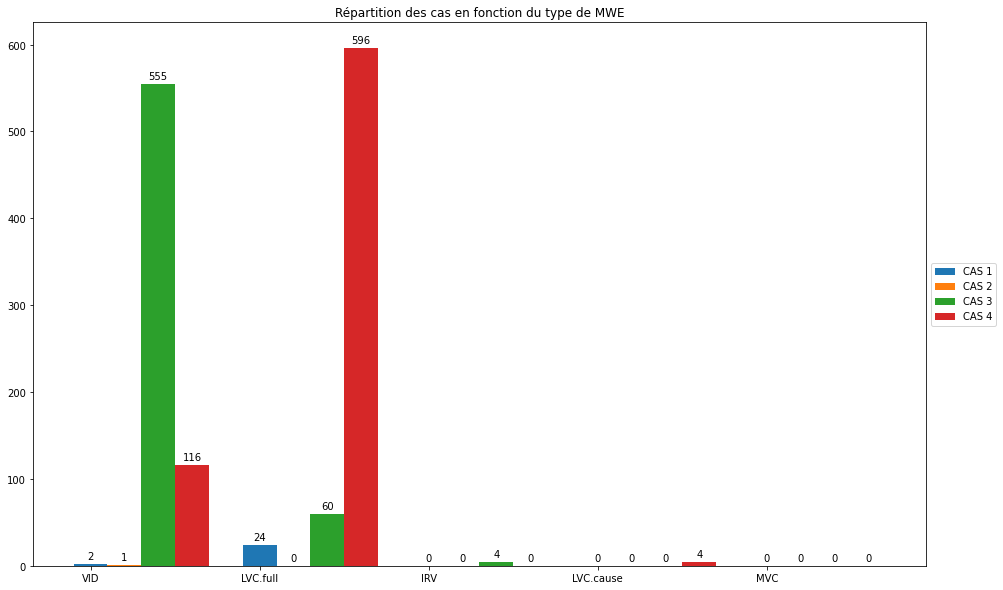

In [9]:
# Cas selon le type de MWE

# Récupérer les infos pour faire le graphique
infos = infos_graphique(minidf, liste_types, 'TYPE', 'CAS')

# Position des infos en abscisses
position, x = position_graphique(len(liste_types), len(infos), barWidth)

# Création du graphique
fig, ax = plt.subplots()
cnt = 0
for cas, type_arr in sorted(infos.items(), key=lambda t: t[0]):
    elt = ax.bar(position[cnt], type_arr, width=barWidth, label=f'CAS {cas}')
    ax.bar_label(elt, padding=3)
    cnt += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(x)
ax.set_xticklabels(liste_types)
ax.set_title("Répartition des cas en fonction du type de MWE")

plt.show()

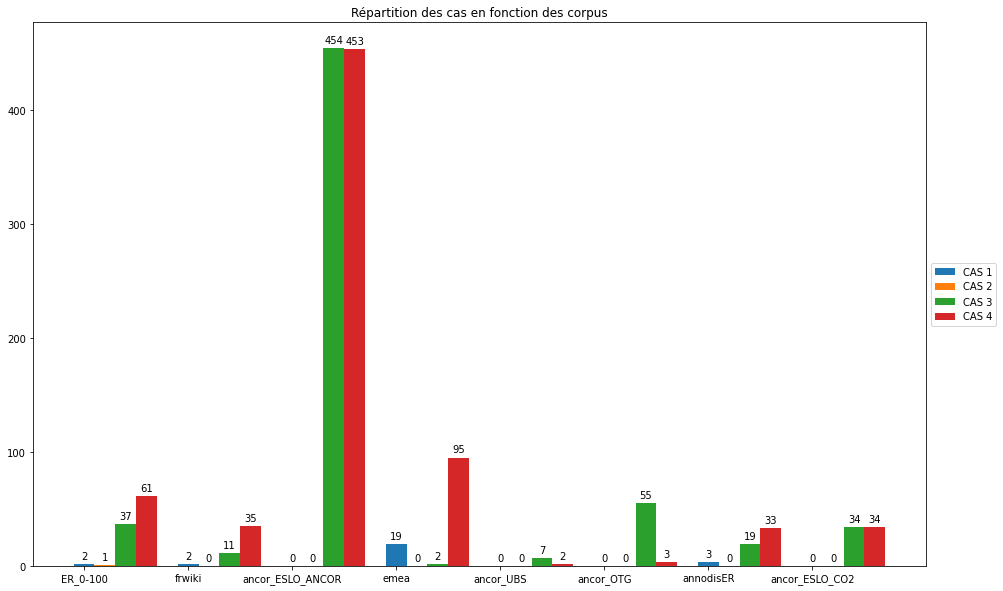

In [10]:
# Cas selon le corpus

# Récupérer les infos pour faire le graphique
infos = infos_graphique(minidf, liste_corpus, 'CORPUS', 'CAS')

# Position des infos en abscisses
position, x = position_graphique(len(liste_corpus), len(infos), barWidth)

# Création du graphique
fig, ax = plt.subplots()
cnt = 0
for cas, corpus_arr in sorted(infos.items(), key=lambda t: t[0]):
    elt = ax.bar(position[cnt], corpus_arr, width=barWidth, label=f'CAS {cas}')
    ax.bar_label(elt, padding=3)
    cnt += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(x)
ax.set_xticklabels(liste_corpus)
ax.set_title("Répartition des cas en fonction des corpus")

plt.show()

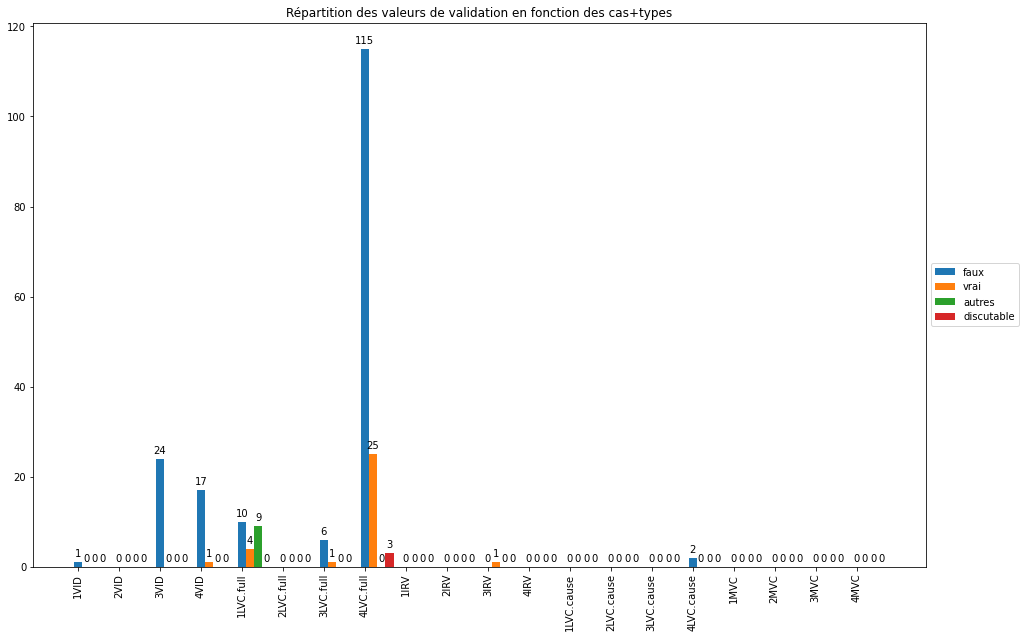

In [11]:
# Validation selon Cas + type
# Pour tous les corpus dont l'annotation en MWE est fiable et
# l'erreur porte forcément sur les mentions ou les chaînes

# Création de la liste des cas + type
liste_castypes = []
for type_mwe in liste_types:
    liste_castypes.extend([f"1{type_mwe}", f"2{type_mwe}", f"3{type_mwe}", f"4{type_mwe}"])

# Ordre des castypes dans les arrays
indices = {}
for ind, castype in enumerate(liste_castypes):
    indices[castype] = ind

# Récupérer les infos pour le graphique
infos = {}
for ind in minidf_2.index:
    val = minidf_2['VALIDATION'][ind]
    if val not in ["vrai", "faux", "discutable"]:
        val = "autres"
    castype = indices[f"{minidf_2['CAS'][ind]}{minidf_2['TYPE'][ind]}"]
    if val in infos:
        infos[val][castype] += 1
    else:
        infos[val] = np.zeros(len(liste_castypes))
        infos[val][castype] += 1

# Position des infos en abscisses
position, x = position_graphique(len(liste_castypes), len(infos), barWidth)

# Création du graphique
fig, ax = plt.subplots()
cnt = 0
for val, castype_arr in infos.items():
    elt = ax.bar(position[cnt], castype_arr, width=barWidth, label=val)
    ax.bar_label(elt, padding=3)
    cnt += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(x)
ax.set_xticklabels(liste_castypes)
ax.set_title("Répartition des valeurs de validation en fonction des cas+types")

plt.xticks(rotation=90)
plt.show()

# Graphiques sur les résultats corrects 

In [12]:
# vraidf : cas - type - corpus - degré de compositionnalité
# Seuls les exemples annotés comme "vrai" (VALIDATION) sont conservés
# Chaque ligne correspond à un cas (parfois plusieurs cas pour une expression trouvée)
dico = {}
cnt = 0
for ind in minidf.index:
    if minidf['VALIDATION'][ind] == "vrai":
        dico[cnt] = {"CAS": minidf['CAS'][ind],
                     "TYPE": minidf['TYPE'][ind],
                     "CORPUS": minidf['CORPUS'][ind],
                     "DEGRE": minidf['DEGRE'][ind]}
        cnt +=1
vraidf = pd.DataFrame(dico).T
vraidf.head(10)

,CAS,TYPE,CORPUS,DEGRE
0,4,LVC.full,ER_0-100,fort
1,4,LVC.full,ER_0-100,fort
2,4,LVC.full,ER_0-100,fort
3,4,LVC.full,ER_0-100,fort
4,4,LVC.full,frwiki,fort
5,3,LVC.full,frwiki,moyen
6,4,VID,frwiki,
7,4,LVC.cause,ancor_ESLO_ANCOR,
8,4,VID,ancor_ESLO_ANCOR,
9,4,VID,ancor_ESLO_ANCOR,


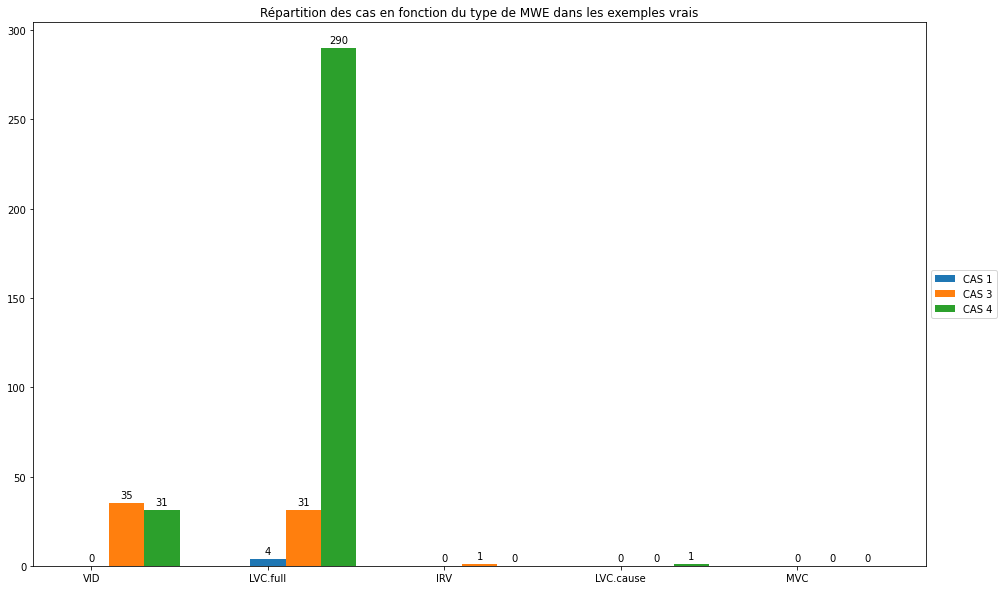

In [13]:
# Vrais selon le type de MWE et du cas

# Récupérer les infos pour faire le graphique
infos = infos_graphique(vraidf, liste_types, 'TYPE', 'CAS')

# Position des infos en abscisses
position, x = position_graphique(len(liste_types), len(infos), barWidth)

# Création du graphique
fig, ax = plt.subplots()
cnt = 0
for cas, type_arr in sorted(infos.items(), key=lambda t: t[0]):
    elt = ax.bar(position[cnt], type_arr, width=barWidth, label=f'CAS {cas}')
    ax.bar_label(elt, padding=3)
    cnt += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(x)
ax.set_xticklabels(liste_types)
ax.set_title("Répartition des cas en fonction du type de MWE dans les exemples vrais")

plt.show()

In [14]:
# Quelque chose avec le degré ?

# Graphiques sur les expressions polylexicales

In [15]:
# mwedf : lemmes - validation_set(ensemble) - validation_list(liste) - degré de compositionnalité(liste) -
# corpus(liste) - Quantité
# mwedf_2 : seulement ANCOR et ER
# Chaque ligne correspond à une expression lemmatisée

dico = {}
dico_2 = {}

for ind in df_resultats.index:
    expression = ""
    doc = " ".join(eval(df_resultats['TOKENS'][ind]))
    doc = nlp(doc)
    for token in doc:
        if expression == "":
            expression = token.lemma_
        else:
            expression = f"{expression} {token.lemma_}"
            
    if expression not in dico:
        dico[expression] = { "TYPE": "",
                             "VALIDATION_SET": [],
                             "VALIDATION_LIST": [],
                             "DEGRE": [],
                             "CORPUS": [],
                             "QUANTITE": 0
                            }

    dico[expression]["TYPE"] = df_resultats['TYPE'][ind]
    if df_resultats['VALIDATION'][ind] not in dico[expression]["VALIDATION_SET"]:
        dico[expression]["VALIDATION_SET"].append(df_resultats['VALIDATION'][ind])
    dico[expression]["VALIDATION_LIST"].append(df_resultats['VALIDATION'][ind])
    if df_resultats['DEGRE DE COMPOSITIONNALITE'][ind] != "":
        dico[expression]["DEGRE"].append(df_resultats['DEGRE DE COMPOSITIONNALITE'][ind])
    if df_resultats['DEGRE DE COMPOSITIONNALITE'][ind] not in dico[expression]["CORPUS"]:
        dico[expression]["CORPUS"].append(df_resultats['CORPUS'][ind])
    dico[expression]["QUANTITE"] += 1

    if "ancor_" in df_resultats['CORPUS'][ind] or "ER_" in df_resultats['CORPUS'][ind]:
        dico_2[expression] = dico[expression]
        
mwedf_2 = pd.DataFrame(dico_2).T
mwedf = pd.DataFrame(dico).T
mwedf.head(10)

,TYPE,VALIDATION_SET,VALIDATION_LIST,DEGRE,CORPUS,QUANTITE
envie donner,LVC.cause,[faux],[faux],[],[ER_0-100],1
rappelon nous,IRV,[faux],[faux],[],[ER_0-100],1
connaître succès,LVC.full,[faux],[faux],[],[ER_0-100],1
prendra décision,LVC.full,[faux],[faux],[],[ER_0-100],1
expérience vivre,LVC.full,[faux],[faux],[],[ER_0-100],1
avoir droit,LVC.full,"[faux, vrai, répétitions]","[faux, faux, faux, vrai, répétitions]",[],"[ER_0-100, frwiki, frwiki, ancor_ESLO_ANCOR, a...",5
tour jouer,LVC.full,[faux],[faux],[],[ER_0-100],1
faire fête,LVC.full,"[faux, vrai]","[faux, faux, vrai]",[],"[ER_0-100, ER_0-100, ancor_ESLO_ANCOR]",3
travail effectua,LVC.full,[faux],[faux],[],[ER_0-100],1
donner accord,LVC.full,[faux],[faux],[],[ER_0-100],1


In [16]:
# Nombre d'expressions différentes (lemmes)
sup_un = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 1]
sup_cinq = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 5]
sup_dix = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 10]
sup_cinquante = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 50]
sup_cent = [ind for ind in mwedf.index if mwedf["QUANTITE"][ind] > 100]

print(f"Il y a {len(mwedf.index)} expressions différentes.")
print(f"Il y a {len(sup_un)} expressions différentes dont le nombre d'occurrence est supérieur à 1.")
print(f"Il y a {len(sup_cinq)} expressions différentes dont le nombre d'occurrence est supérieur à 5.")
print(f"\nIl y a {len(sup_dix)} expressions différentes dont le nombre d'occurrence est supérieur à 10 :")
for mwe in sup_dix:
    print(f"- {mwe}")
print(f"\nIl y a {len(sup_cinquante)} expressions différentes dont le nombre d'occurrence est supérieur à 50 :")
for mwe in sup_cinquante:
    print(f"- {mwe}")
print(f"\nIl y a {len(sup_cent)} expressions différentes dont le nombre d'occurrence est supérieur à 100 :")
for mwe in sup_cent:
    print(f"- {mwe}")
        

Il y a 430 expressions différentes.
Il y a 145 expressions différentes dont le nombre d'occurrence est supérieur à 1.
Il y a 27 expressions différentes dont le nombre d'occurrence est supérieur à 5.

Il y a 13 expressions différentes dont le nombre d'occurrence est supérieur à 10 :
- en avoir
- avoir le temps
- faire cela
- cela faire
- faite travail
- faire étude
- avoir question
- avoir difficulté
- poser question
- prendre sanction
- avoir problème
- avoir problèm
- faire grever

Il y a 3 expressions différentes dont le nombre d'occurrence est supérieur à 50 :
- en avoir
- cela faire
- faire étude

Il y a 1 expressions différentes dont le nombre d'occurrence est supérieur à 100 :
- en avoir


In [17]:
# VID et LVC.full les plus courantes
vid = {}
lvcfull = {}
for mwe in mwedf.index:
    if mwedf['TYPE'][mwe] == "VID":
        vid[mwe] = mwedf['QUANTITE'][mwe]
    if mwedf['TYPE'][mwe] == "LVC.full":
        lvcfull[mwe] = mwedf['QUANTITE'][mwe]
vid = sorted(vid, key=vid.get, reverse=True)[:10]
lvcfull = sorted(lvcfull, key=lvcfull.get, reverse=True)[:10]

print("Les VID les plus courantes sont :")
for mwe in vid:
    print(f"- {mwe}\t{mwedf['QUANTITE'][mwe]}")

print("\nLes LVC.full les plus courantes sont :")
for mwe in lvcfull:
    print(f"- {mwe}\t{mwedf['QUANTITE'][mwe]}")


Les VID les plus courantes sont :
- en avoir	277
- cela faire	73
- avoir le temps	40
- faire cela	27
- avoir raison	10
- vous poser question	10
- fait votre temps	10
- il rester	9
- en vouloir	5
- prendre le temps	4

Les LVC.full les plus courantes sont :
- faire étude	52
- avoir difficulté	17
- poser question	16
- avoir problème	16
- prendre sanction	15
- faite travail	14
- avoir question	14
- faire grever	14
- avoir problèm	13
- avoir habitude	9


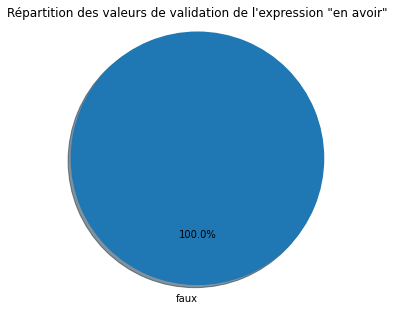

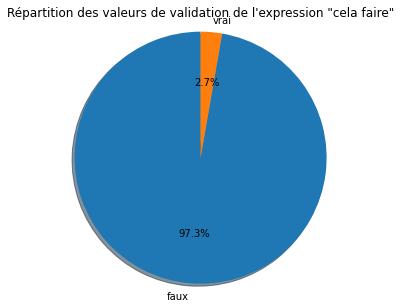

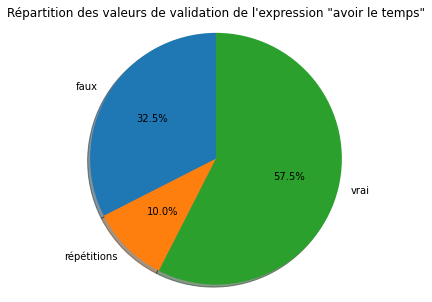

In [18]:
# Répartitions de la validation des 3 VID les plus courantes
# en avoir / cela faire / avoir le temps

camembert_validation(mwedf_2, ["en avoir"])
camembert_validation(mwedf_2, ["cela faire"])
camembert_validation(mwedf_2, ["avoir le temps"])

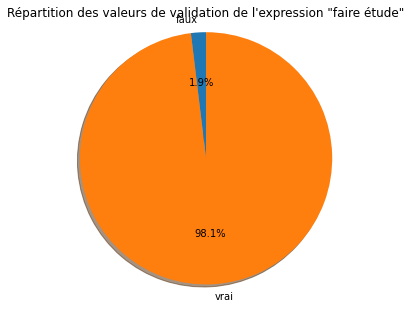

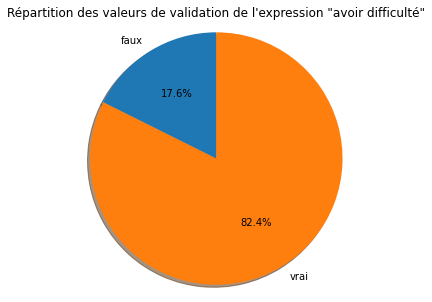

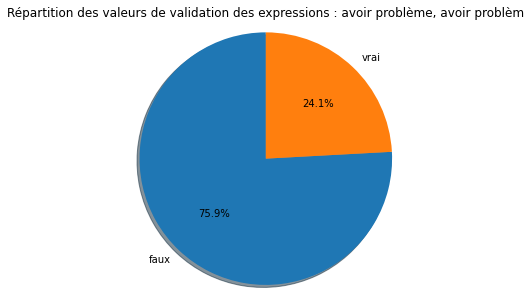

In [19]:
# Répartitions de la validation des 3 LVC.full les plus courantes
# subir icp / atteindre insuffisance / avoir problème ou problem

camembert_validation(mwedf_2, ["faire étude"])
camembert_validation(mwedf_2, ["avoir difficulté"])
camembert_validation(mwedf_2, ["avoir problème", "avoir problèm"])